##### SME0202 Métodos Numéricos em Equações Diferenciais Ordinárias
### Trabalho 1 - Equações Elípticas - Meios Anisotrópicos e Termo de Arraste
- Cody Stefano Barham Setti - 4856322
- Ian de Holanda Cavalcanti Bezerra - 13835412

### Importando pacotes

In [1]:
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

### Preparando constante convectiva e funcao que expressa a solucao exata

In [2]:
# Constante C
c = 4*np.pi**2 -3


# Solucao Exata do Problema

def u(x,y):
    return np.exp(-y)*np.sin(2*np.pi*x)

In [3]:

def print_matrix(matrix):  # Funcao auxiliar para printar uma matriz de forma organizada
    # Pega a largura máxima precisa para qualquer elemento
    max_width = max(len(str(element)) for row in matrix for element in row)
    
    for line in matrix:
        # Formata cada elemento para que tenha largura consistente
        formatted_row = [str(element).rjust(max_width) for element in line]
        print(" ".join(formatted_row))

### Montando o sistema linear de equacoes (solucao numerica)

In [26]:
def idx(i,j, Nj):
    return (i-1)*Nj + j


def solve_convection_diffusion_one_sided(h):
    print(f"Resolvendo para h={h}")

    #--------------------------------
    
    # Criando Malha
    x = np.arange(0, 1 + h, h)
    y = np.arange(-1, 1 + h, h)

    Nx, Ny = len(x), len(y)   # Definindo Numero de Linhas e Colunas
    c = 4*np.pi**2 - 3        # Constante convectiva

    # Variaveis auxiliares
    Ni, Nj = Nx-2, Ny   
    N = Ni * Nj         # Numero de Incognitas

    #--------------------------------
    
    """
    -> Usando a condicao de Neumann: j == 0
    
        u_y = -e*sin(2πx)  Borda Inferior
    
    -> Usando a condicao de Robin: j == Ny-1
   
        u_y + u = 0  Borda Superior

    """
    f_bottom = - np.e * np.sin(2*np.pi * x[1:-1])

    A = sp.lil_matrix((N, N))
    F = np.zeros(N)

    axx = 1/h**2
    ayy = 3/h**2
    adv = c/(2*h)

    #--------------------------------
    
    for i in range(1, Nx-1):
        for j in range(Ny):
            k = idx(i,j, Nj)
            if j == 0:
                # Diferenca progressiva de 3 pontos para u_y = f_bottom
                A[k, idx(i,0, Nj)]   += -3/(2*h)
                A[k, idx(i,1, Nj)]   +=  4/(2*h)
                A[k, idx(i,2, Nj)]   += -1/(2*h)
                
                F[k] = f_bottom[i-1]

            elif j == Ny-1:
                # Diferenca regressiva de 3 pontos + Condicao de Robin: u_y + u = 0
                A[k, idx(i,Ny-3, Nj)] +=  1/(2*h)
                A[k, idx(i,Ny-2, Nj)] += -4/(2*h)
                A[k, idx(i,Ny-1, Nj)] +=  3/(2*h) + 1

            else:
                # Discretizacao da Equacao de Poisson: u_xx + 3 u_yy - c u_y = 0
                # Direcao x
                A[k, k]           += -2*axx
                if i+1 < Nx-1:    A[k, idx(i+1,j, Nj)] +=  axx
                if i-1 >  0:      A[k, idx(i-1,j, Nj)] +=  axx

                # Direcao y
                A[k, k]           += -2*ayy
                A[k, idx(i,  j+1, Nj)] +=  ayy
                A[k, idx(i,  j-1, Nj)] +=  ayy

                # Termo Convectivo: -c * (u_{j+1}-u_{j-1})/(2h)
                A[k, idx(i, j+1, Nj)] += -adv
                A[k, idx(i, j-1, Nj)] +=  adv

    #--------------------------------
    
    A = A.tocsr()   # Transformando em matriz esparsa formato CSR    
    Uvec = spla.spsolve(A, F)
    return x, y, Nx, Ny,Nj, Uvec


# Reconstruindo a solucao 2D a partir da solucao 1D
def recriar_malha(Nx, Ny, Nj, Uvec, idx):
    U = np.zeros((Nx,Ny))
    for i in range(1, Nx-1):
        for j in range(Ny):
            U[i,j] = Uvec[idx(i,j, Nj)]
    return U

# Rodando para um exemplo h = 0.01

h = 0.01
x, y, Nx, Ny, Nj, Uvec = solve_convection_diffusion_one_sided(h)
U_2d = recriar_malha(Nx, Ny, Nj,  Uvec, idx)
X, Y = np.meshgrid(x, y, indexing='ij')

print("Observe que as bordas laterais possuem valor nulo!")
print_matrix(U_2d.T)

Resolvendo para h=0.01
Observe que as bordas laterais possuem valor nulo!
                    0.0      0.1707427129038212     0.34081158232473674      0.5095354241322176      0.6762483624052412      0.8402924573403401      1.0010203018394241       1.157797576529822      1.3100055531330557       1.457043536302682      1.5983312342943947      1.7333110491124295      1.8614502770941113      1.9822432112478419      2.0952131370475584      2.1999142138071788      2.2959332342101044       2.382891255049724      2.4604450927451245      2.5282886777298974       2.586154262368895      2.6338134776358206       2.671078234381438       2.697801465635521      2.7138777070129905      2.7192435129336694      2.7138777070129914      2.6978014656355183       2.671078234381432      2.6338134776358126      2.5861542623688853       2.528288677729884      2.4604450927451076       2.382891255049707      2.2959332342100875        2.19991421380716       2.095213137047539       1.982243211247823      1.8614502

#### Plotando solucoes numerica e exata

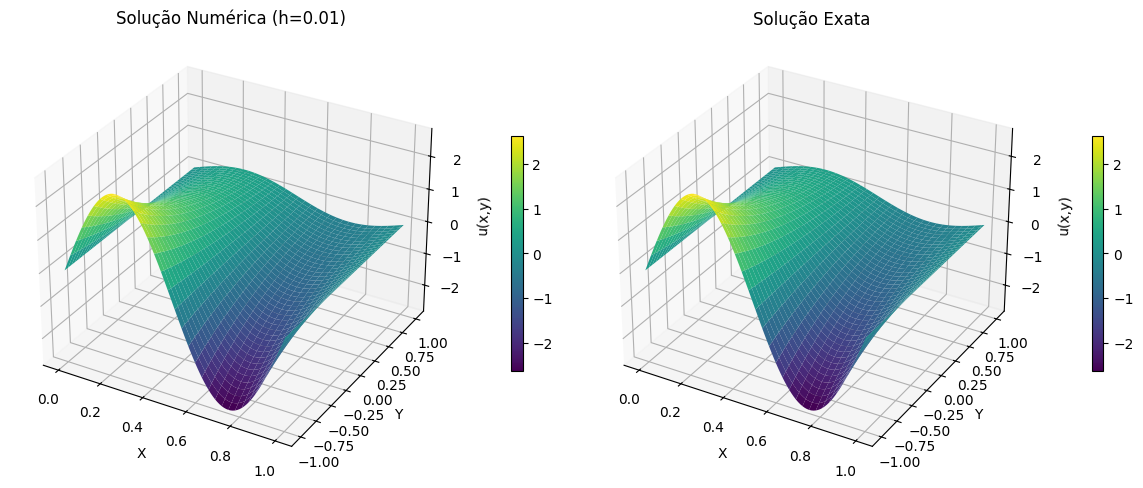

In [5]:
# Preparando Grid
exata = u(X,Y)


# Plotando Solucao Numerica e Exata

fig = plt.figure(figsize=(12, 5))

# Primeiro subplot para solucao numerica
ax1 = fig.add_subplot(121, projection='3d')
surf1 = ax1.plot_surface(X, Y, U_2d, cmap='viridis')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('u(x,y)')
ax1.set_title(f'Solução Numérica (h={h})')
fig.colorbar(surf1, ax=ax1, shrink=0.5, pad=0.1)



# Segundo subplot para solucao exata
ax2 = fig.add_subplot(122, projection='3d')
surf2 = ax2.plot_surface(X, Y, exata, cmap='viridis')
ax2.set_title('Solução Exata')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('u(x,y)')
fig.colorbar(surf2, ax=ax2, shrink=0.5, pad=0.1)

plt.tight_layout()
plt.show()

Dimensão de exata: (101, 201)
Dimensão de U_2d: (101, 201)


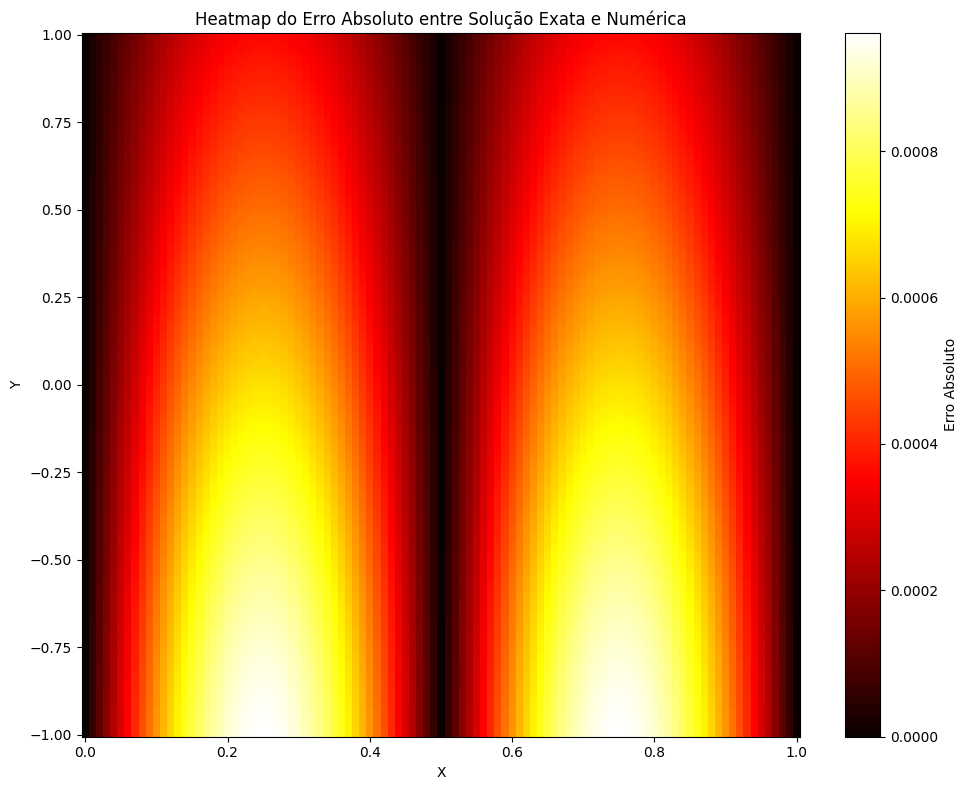

Erro máximo: 9.616845e-04
Erro médio: 4.248885e-04


In [6]:
# Verificando as dimensões das matrizes
print(f"Dimensão de exata: {exata.shape}")
print(f"Dimensão de U_2d: {U_2d.shape}")


# Calculando o erro absoluto entre a solução exata e numérica
erro_absoluto = np.abs(exata - U_2d)

# Criando um heatmap do erro
plt.figure(figsize=(10, 8))
heatmap = plt.pcolormesh(X, Y, erro_absoluto, cmap='hot', shading='auto')
plt.colorbar(heatmap, label='Erro Absoluto')
plt.title('Heatmap do Erro Absoluto entre Solução Exata e Numérica')
plt.xlabel('X')
plt.ylabel('Y')
plt.tight_layout()
plt.show()

# Calculando estatísticas do erro
erro_maximo = np.max(erro_absoluto)
erro_medio = np.mean(erro_absoluto)
print(f"Erro máximo: {erro_maximo:.6e}")
print(f"Erro médio: {erro_medio:.6e}")


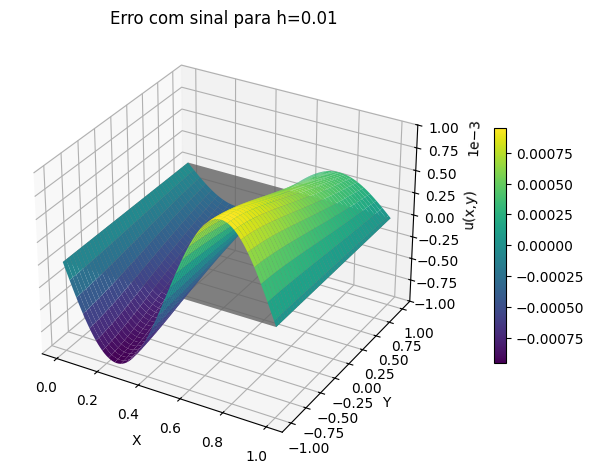

In [27]:
# Calculando o erro com sinal entre a solução exata e numérica
erro = exata - U_2d

fig = plt.figure(figsize=(12, 5))

# Plot de erro com sinal
ax1 = fig.add_subplot(121, projection='3d')
surf1 = ax1.plot_surface(X, Y, erro, cmap='viridis')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('u(x,y)')
ax1.set_title(f'Erro com sinal para h={h}')
fig.colorbar(surf1, ax=ax1, shrink=0.5, pad=0.1)

# Configurar notação científica para o eixo z
ax1.ticklabel_format(axis='z', style='sci', scilimits=(0,0))

# Adicionar plano xy (z=0) para melhor visualização
x_min, x_max = X.min(), X.max()
y_min, y_max = Y.min(), Y.max()
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 2), np.linspace(y_min, y_max, 2))
zz = np.zeros(xx.shape)
ax1.plot_surface(xx, yy, zz, alpha=0.8, color='gray')

plt.tight_layout()
plt.show()

### Tarefa 3: Estudo de convergência do método numérico

Resolvendo para h=0.2
Erro médio para h=0.2: 1.501770e-01
Resolvendo para h=0.1
Erro médio para h=0.1: 3.839989e-02
Resolvendo para h=0.05
Erro médio para h=0.05: 1.016937e-02
Resolvendo para h=0.025
Erro médio para h=0.025: 2.613106e-03
Resolvendo para h=0.0125
Erro médio para h=0.0125: 6.621195e-04
Resolvendo para h=0.00625
Erro médio para h=0.00625: 1.666354e-04
Resolvendo para h=0.003125
Erro médio para h=0.003125: 4.179705e-05
Resolvendo para h=0.0015625
Erro médio para h=0.0015625: 1.046654e-05
[0.2, 0.1, 0.05, 0.025, 0.0125, 0.00625, 0.003125, 0.0015625]
[1.50176965e-01 3.75442412e-02 9.38606030e-03 2.34651507e-03
 5.86628769e-04 1.46657192e-04 3.66642980e-05 9.16607451e-06]


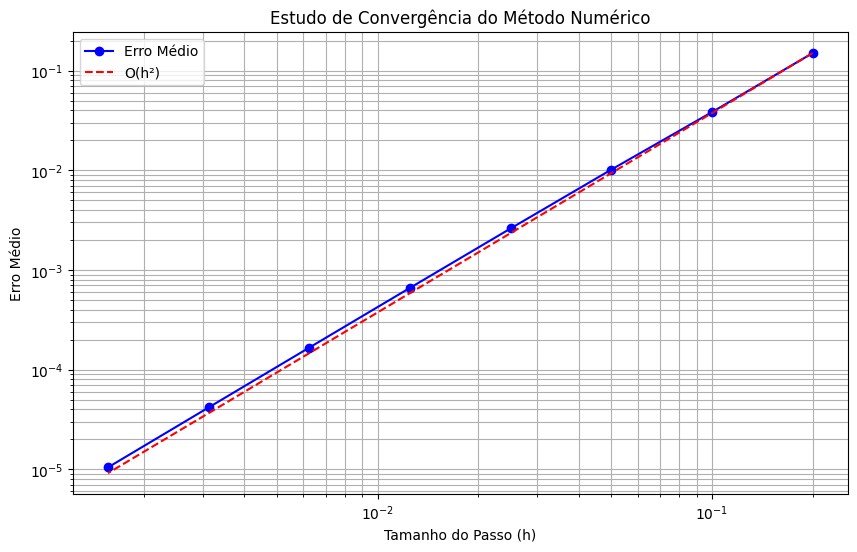

In [28]:
def estudo_de_convergencia(h_values):
    errors = []
    for hi in h_values:
        # Usando hi para cada valor de h
        x, y, Nx, Ny, Nj, Uvec = solve_convection_diffusion_one_sided(hi)
        
        # Recalculando a solução exata para a malha atual
        X, Y = np.meshgrid(x, y)
        exata = u(X,Y)
        
        # Reconstruindo a malha da solução numérica
        U_2d = recriar_malha(Nx, Ny, Nj, Uvec, idx)


        erro_absoluto = np.abs(exata - U_2d.T)
        erro_medio = np.mean(erro_absoluto)

        errors.append(erro_medio)
        print(f"Erro médio para h={hi}: {erro_medio:.6e}")
    return errors


h_values = [0.2, 0.1, 0.05, 0.025, 0.0125, 0.00625, 0.003125, 0.0015625]
errors = estudo_de_convergencia(h_values)


# Plotando em escala log-log para visualizar melhor a ordem de convergência
plt.figure(figsize=(10, 6))
plt.loglog(h_values, errors, marker='o', linestyle='-', color='b', label='Erro Médio')

# Adicionando linha de referência para convergência de segunda ordem
h_ref = np.array(h_values)

err_ref = np.zeros(len(h_values))

for i in range(len(h_values)):
    err_ref[i] = (errors[0] * (h_values[i]/h_values[0])**2)

print(h_values)
print(err_ref)


plt.loglog(h_values, err_ref, 'r--', label='O(h²)')

plt.xlabel('Tamanho do Passo (h)')
plt.ylabel('Erro Médio')
plt.title('Estudo de Convergência do Método Numérico')
plt.legend()


# Mostrando o gráfico
plt.grid(True, which='both')
plt.show()